[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)   
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)

single-super-droplet iterative parcel simulation based on [Rozanski & Sonntag 1982](https://doi.org/10.3402/tellusa.v34i2.10795)

**TODO #1207**:
- rainfall representation?
- Fig. 6
- asserts for T step
- asserts for T final
- switch to the same fractionation formulae as used in the paper
- move eq. 2 to formulae
- smoke tests

In [1]:
import os
from open_atmos_jupyter_utils import show_plot
from matplotlib import pyplot, ticker
from PySDM.physics import si, in_unit
from PySDM import Formulae, Builder, products, dynamics
from PySDM.environments import Parcel
from PySDM.backends import CPU
from PySDM.products.impl.moist_environment_product import MoistEnvironmentProduct
from PySDM_examples.utils import BasicSimulation
from PySDM_examples.utils.widgets import FloatProgress, display
import numpy as np

In [14]:
formulae = Formulae(
    isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994',
    isotope_meteoric_water_line_excess='Dansgaard1964',
    isotope_ratio_evolution='MerlivatAndJouzel1979',
)
BACKEND = CPU(formulae, override_jit_flags={'parallel': False})
const = formulae.constants
trivia = formulae.trivia
CI = 'CI' in os.environ

FIG4_CAPTION_PARAMS = {
    'T_init': const.T0 + 25 * si.K,
    'T_fini': const.T0 - 10 * si.K,
    'T_step': 2 * si.K,
    'P_init': 1000 * si.mbar,
    'RH_init': 80 * const.PER_CENT,
    
    # note: R0 in the caption, but negative, hence delta
    'delta_2H_init': -74.7 * const.PER_MILLE,
    # the "K" parameter
    'isotope_exchange_factor': 1,
    # the "N_L" parameter, note: mixing ratio in the caption, but per-volume units, hence density; assuming 1 kg/m3
    'autoconversion_mixrat_threshold': 1 * si.g / si.m**3 / (1 * si.kg / si.m**3)
}

ARBITRARY_PARAMS = {
    'delta_18O_init': formulae.isotope_meteoric_water_line_excess.d18O_of_d2H(
        delta_2H=FIG4_CAPTION_PARAMS['delta_2H_init']
    ),
    'N_SUPER_DROPLETS': 1,
    'N_OUTPUT_INTERVALS': 71,
    'N_ITERATIONS': 501,
    'N_PLOT_PROFILES': 10 if not CI else 1,
}
ARBITRARY_PARAMS['PARCEL_CTOR_ARGS'] = {
    'p0': FIG4_CAPTION_PARAMS['P_init'],
    'initial_water_vapour_mixing_ratio': const.eps / (
        FIG4_CAPTION_PARAMS['P_init']
        / FIG4_CAPTION_PARAMS['RH_init']
        / formulae.saturation_vapour_pressure.pvs_Celsius(FIG4_CAPTION_PARAMS['T_init'] - const.T0)
        - 1
    ),
    'T0': FIG4_CAPTION_PARAMS['T_init'],
    'w': 1 * si.m / si.s,
    'mass_of_dry_air': 1 * si.kg,
    'dt': 100 * si.s,
}
ARBITRARY_PARAMS['INIT_ATTRIBUTES'] = Builder(
    n_sd=ARBITRARY_PARAMS['N_SUPER_DROPLETS'],
    backend=BACKEND,
    environment=Parcel(**ARBITRARY_PARAMS['PARCEL_CTOR_ARGS'])
).particulator.environment.init_attributes(
    kappa = 1,
    r_dry = .1 * si.um,
    n_in_dv = (1000 / si.cm**3) * si.m**3,
)

ISOTOPES = ("2H", "18O")

assert (ARBITRARY_PARAMS['N_ITERATIONS'] - 1) % ARBITRARY_PARAMS['N_PLOT_PROFILES'] == 0

In [15]:
def Rv_prim(*, Rl, Nl, Rv, Nv, dNl, Rr, K, a):
    return (
        Rl * Nl + Rv * Nv + dNl * Rr * K
    ) / (
        (Nl + dNl * K) * a + Nv
    )

class MultiBox(Parcel):
    """ iterative parcel model in which each new iteration operates with ambient isotopic profile 
    resultant from the previous iteration, leading to a stationary state
    """
    def __init__(self, *, isotopes, delta_nl, rain_isotope_ratios, **kwargs):
        super().__init__(variables=[f"{ratio}_{isotope}" for ratio in ("Rv", "Rr") for isotope in isotopes], **kwargs)
        self.isotopes = isotopes
        self.delta_nl = delta_nl
        self.rain_isotope_ratios = rain_isotope_ratios
    
    def advance_parcel_vars(self):
        """ explicit Euler integration of isotope-ratio time derivative """
        self._recalculate_temperature_pressure_relative_humidity(self._tmp)

        alpha_old = {}
        dRv__dt = {}
        for isotope in self.isotopes:
            alpha_fun = getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_l_{isotope}')
            alpha_old[isotope] = alpha_fun(self["T"][0])
            alpha_new = alpha_fun(self._tmp["T"][0])
            
            dRv__dt[isotope] = self[f'Rv_{isotope}'][0] * self.formulae.isotope_ratio_evolution.d_Rv_over_Rv(
                alpha=alpha_old[isotope],
                d_alpha=(alpha_new - alpha_old[isotope]) / self.dt,
                n_vapour=self['water_vapour_mixing_ratio'][0],
                d_n_vapour=-self.delta_liquid_water_mixing_ratio / self.dt,
                n_liquid=FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold']  # TODO #1207
            )
            
        super().advance_parcel_vars()

        for isotope in self.isotopes:
            self.particulator.backend.explicit_euler(self._tmp[f"Rv_{isotope}"], self.particulator.dt, dRv__dt[isotope])
            level = self.particulator.n_steps
            if self.delta_nl is not None:
                self._tmp[f"Rv_{isotope}"][:] = Rv_prim(
                    Rl=alpha_old[isotope] * self._tmp[f'Rv_{isotope}'][0],
                    Nl=FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'],
                    Rv=self._tmp[f'Rv_{isotope}'][0],
                    Nv=self['water_vapour_mixing_ratio'][0],
                    dNl=np.sum(self.delta_nl[level:]),
                    Rr=self.rain_isotope_ratios[isotope][min(
                        level + 2,  # TODO #1207: this warrants a comment...
                        ARBITRARY_PARAMS['N_OUTPUT_INTERVALS']
                    )],
                    K=FIG4_CAPTION_PARAMS["isotope_exchange_factor"],
                    a=alpha_old[isotope]
                )
            self._tmp[f"Rr_{isotope}"][:] = alpha_old[isotope] * self._tmp[f"Rv_{isotope}"][0]

class AmbientIsotopicRatio(MoistEnvironmentProduct):
    """ product class for any ambient isotopic ratio """
    def __init__(self, name=None, unit="dimensionless", var=None):
        super().__init__(name=name, unit=unit, var=var)

In [16]:
class Simulation(BasicSimulation):  # pylint:disable=too-few-public-methods
    """ simulation framework mimicking the workflow from R&S 1982 paper """
    def __init__(self, *, isotopes, delta_nl, rain_isotope_ratios):
        env = MultiBox(
            **ARBITRARY_PARAMS['PARCEL_CTOR_ARGS'],
            delta_nl=delta_nl,
            rain_isotope_ratios=rain_isotope_ratios,
            isotopes=isotopes,
        )
        builder = Builder(
            n_sd=ARBITRARY_PARAMS['N_SUPER_DROPLETS'],
            backend=BACKEND,
            environment=env
        )
        builder.add_dynamic(dynamics.AmbientThermodynamics())
        builder.add_dynamic(dynamics.Condensation())

        for isotope in isotopes:
            env[f"Rv_{isotope}"][:] = formulae.trivia.isotopic_delta_2_ratio(
                delta=(FIG4_CAPTION_PARAMS if isotope == "2H" else ARBITRARY_PARAMS)[f'delta_{isotope}_init'],
                reference_ratio=getattr(const, f"VSMOW_R_{isotope}")
            )
        
        super().__init__(particulator = builder.build(
            attributes=ARBITRARY_PARAMS['INIT_ATTRIBUTES'],
            products=(
                products.ParcelDisplacement(name="z"),
                products.AmbientTemperature(var='T', name='T'),
                products.AmbientRelativeHumidity(var='RH', name="RH"),
                products.AmbientWaterVapourMixingRatio(var='water_vapour_mixing_ratio', name='QV'),
                *[
                    AmbientIsotopicRatio(
                        name=f'{ratio}_{isotope}',
                        var=f"{ratio}_{isotope}"
                    ) for isotope in isotopes for ratio in ('Rv', 'Rr')
                ]
            )
        ))

    def run(self, nt):
        retval = self._run(nt=nt, steps_per_output_interval=1)
        for k, v in retval.items():
            retval[k] = np.asarray(v)
        retval["QL"] = ARBITRARY_PARAMS['PARCEL_CTOR_ARGS']['initial_water_vapour_mixing_ratio'] - retval['QV']
        return retval

In [17]:
iter_state = {
    'delta_nl': None,
    'rain_isotope_ratios': None
}
output = []
level_indices = {}

progbar = FloatProgress(value=0, min=0, max=1)
display(progbar)

for iteration in range(ARBITRARY_PARAMS['N_ITERATIONS']):
    progbar.value = (iteration + 1) / ARBITRARY_PARAMS['N_ITERATIONS']
    simulation = Simulation(
        delta_nl=iter_state['delta_nl'],
        rain_isotope_ratios=iter_state['rain_isotope_ratios'],
        isotopes=ISOTOPES
    )
    tmp = simulation.run(nt=ARBITRARY_PARAMS['N_OUTPUT_INTERVALS'])
    iter_state['rain_isotope_ratios'] = {
        isotope: tmp[f'Rr_{isotope}'] for isotope in ISOTOPES
    }
    if iteration == 0:
        tmp['QR'] = np.maximum(0, tmp['QL'] - FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'])
        tmp['QL'] = np.minimum(tmp['QL'], FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'])
        iter_state['delta_nl'] = np.diff(np.concatenate(([0], tmp['QR']))) # TODO #1207: per delta-T (which is not constant!!!)
        level_indices['CB'] = np.argmin(tmp['RH'] < 1)
        level_indices['FRL'] = np.amin(np.argmax(tmp['QL']))
    output.append(tmp)

FloatProgress(value=0.0, max=1.0)

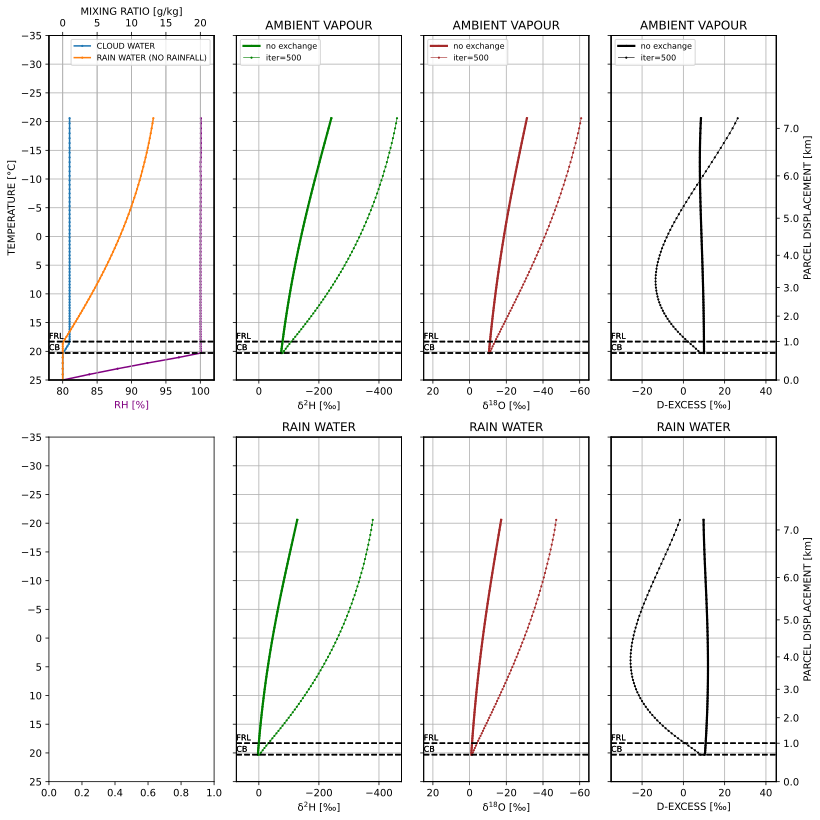

HTML(value="<a href='./fig_4.pdf' target='_blank'>./fig_4.pdf</a><br>")

In [18]:
temp_C = output[0]["T"] - const.T0
alt_km = in_unit(output[0]["z"], si.km) 

fig, axs = pyplot.subplots(2, 4, squeeze=False, sharey=True, figsize=(11.5, 11.5), tight_layout=True)

plot_kwargs = {
    'markersize': 2.5,
    'marker': '.'
}

axs[0,0].set_ylabel('TEMPERATURE [°C]')
axs[0,0].set_ylim(25, -35)
axs[0,0].yaxis.set_major_locator(ticker.MultipleLocator(5))

axs[0,0].plot(
    output[0]['RH'] / const.PER_CENT,
    temp_C,
    color='purple',
    label='RH',
    **plot_kwargs
)
axs[0,0].set_xlabel('RH [%]', color='purple')
axs[0,0].set_xlim(80-2, 100+2)
axs[0,0].grid()

twin = axs[0,0].twiny()
twin.plot(
    in_unit(output[0]['QL'], si.g / si.kg),
    temp_C,
    label='CLOUD WATER',
    **plot_kwargs
)
twin.plot(
    in_unit(output[0]['QR'], si.g / si.kg),
    temp_C,
    label='RAIN WATER (NO RAINFALL)',
    **plot_kwargs,
)
twin.set_xlabel('MIXING RATIO [g/kg]')
twin.set_xlim(-2, 20+2)
twin.grid()
twin.legend(fontsize=8)

for plot_row, ratio, title in ((0, "Rv", "AMBIENT VAPOUR"), (1, "Rr", "RAIN WATER")):
    for iteration in range(
        0,
        ARBITRARY_PARAMS['N_ITERATIONS'],
        (ARBITRARY_PARAMS['N_ITERATIONS']-1) // ARBITRARY_PARAMS['N_PLOT_PROFILES']
    ):
        deltas = {
            iso: formulae.trivia.isotopic_ratio_2_delta(
                ratio=output[iteration][f'{ratio}_{iso}'][level_indices['CB']:],
                reference_ratio=getattr(const, f"VSMOW_R_{iso}")
            ) for iso in ISOTOPES
        }
    
        iter_kwargs = {
            'linewidth': 2.2 - 1.6 * iteration / ARBITRARY_PARAMS['N_ITERATIONS'],
            'label': ('no exchange' if iteration == 0 else f"iter={iteration}"),
            **plot_kwargs
        }
        
        for ax, iso, color in ((axs[plot_row, 1], '2H', 'green'), (axs[plot_row, 2], "18O", 'brown')):
            ax.set_title(title)
            ax.plot(
                in_unit(deltas[iso], const.PER_MILLE),
                temp_C[level_indices['CB']:],
                color=color,
                **iter_kwargs
            )
        axs[plot_row, 3].plot(
            in_unit(
                formulae.isotope_meteoric_water_line_excess.excess_d(delta_2H=deltas["2H"], delta_18O=deltas["18O"]),
                const.PER_MILLE
            ),
            temp_C[level_indices['CB']:],
            color='black',
            **iter_kwargs
        )
        axs[plot_row, 3].set_title(title)
    
    axs[plot_row, 1].set_xlabel('δ$^{2}$H [‰]')
    axs[plot_row, 1].set_xlim(75, -475)
    axs[plot_row, 1].grid()
    
    axs[plot_row, 2].set_xlabel('δ$^{18}$O [‰]')
    axs[plot_row, 2].set_xlim(25, -65)
    axs[plot_row, 2].grid()
    
    if plot_row == 0:
        axs[plot_row, 1].legend(loc="upper left", fontsize=8)
        axs[plot_row, 2].legend(loc="upper left", fontsize=8)
        axs[plot_row, 3].legend(loc="upper left", fontsize=8)
    
    axs[plot_row, 3].grid()
    axs[plot_row, 3].set_xlim(-35, 45)
    axs[plot_row, 3].set_xlabel("D-EXCESS [‰]")
    twin = axs[plot_row, 3].twinx()
    twin.set_ylabel('PARCEL DISPLACEMENT [km]')
    twin.set_ylim(axs[plot_row, 2].get_ylim())
    twin.set_yticks(*[
        [prof[i] for i in range(0, ARBITRARY_PARAMS['N_OUTPUT_INTERVALS'], 10)] for prof in (temp_C, alt_km)
    ])
    
    for i, ax in enumerate(axs.flatten()):
        if i == 4:
            continue
        twinx = ax.twiny()
        twinx.set_xlim(0, 1)
        twinx.set_xticks([])
        for label, level_index in level_indices.items():
            twinx.plot([0, 1], [temp_C[level_index]]*2, color='black', linestyle='--')
            twinx.text(0, temp_C[level_index] - .5, label, fontsize=8)

show_plot('fig_4.pdf')

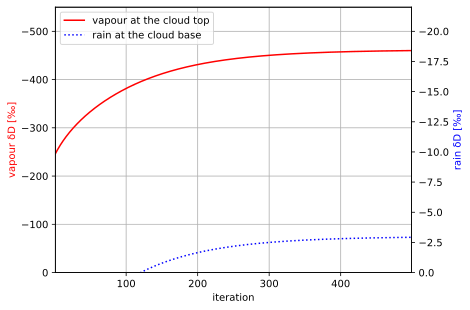

HTML(value="<a href='./fig_5.pdf' target='_blank'>./fig_5.pdf</a><br>")

In [19]:
data = {
    lev: {
        k: np.asarray([
            output[i][k][lev]
            for i in range(ARBITRARY_PARAMS['N_ITERATIONS'])
        ])
        for k in ('Rv_2H', 'Rr_2H')
    }
    for lev in (-1, level_indices['CB'])
}

colors = {'vapour': 'red', 'rain': 'blue'}

lines = []
lines.append(*pyplot.plot(
    in_unit(formulae.trivia.isotopic_ratio_2_delta(
        ratio=data[-1]["Rv_2H"][1:],
        reference_ratio=const.VSMOW_R_2H
    ), const.PER_MILLE),
    label="vapour at the cloud top",
    color=colors['vapour']
))
pyplot.ylim(0, -550)
pyplot.ylabel('vapour δD [‰]', color=colors['vapour'])

pyplot.xlim(1, ARBITRARY_PARAMS['N_ITERATIONS']-2)
pyplot.xlabel('iteration')
pyplot.grid()

twinx = pyplot.gca().twinx()
twinx.set_ylim(0, -22)
twinx.set_ylabel('rain δD [‰]', color=colors['rain'])
lines.append(*twinx.plot(
    in_unit(formulae.trivia.isotopic_ratio_2_delta(
        ratio=data[level_indices['CB']]["Rr_2H"][1:],
        reference_ratio=const.VSMOW_R_2H
    ), const.PER_MILLE),
    label="rain at the cloud base",
    color=colors['rain'],
    linestyle=':'
))
pyplot.legend(lines, [l.get_label() for l in lines], loc='upper left')
show_plot('fig_5.pdf')